# Dynamic mode decomposition with control on a linear system
Dynamic mode decomposition with control (DMDc) aims to disambiguate the effect of control/actuation
from the unforced dynamics.
We apply DMDc to a low-dimensional, linear system
(this is example in Sec. 4 in Proctor et al., _"Dynamic Mode Decomposition with Control"_, SIAM 2016).

$$x_{k+1} =\begin{bmatrix} 1.5 & 0\\ 0 & 0.1 \end{bmatrix}x_k + \begin{bmatrix} 1\\ 0 \end{bmatrix} u_k$$

We first import the pyKoopman package and other packages for plotting and matrix manipulation.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.cm as cm

import pykoopman as pk

Define state and control matrices of the linear control system and collect data.

In [2]:
A = np.matrix([[1.5, 0],[0, 0.1]])
B = np.matrix([[1],[0]])

def advance_linear_system(x0,u,n,A=A,B=B):
    # A = np.matrix([[1.5, 0],[0, 0.1]])
    # B = np.matrix([1,0])
    x = np.zeros([n,len(x0)])
    x[0,:] = x0
    for i in range(n-1):
        x[i+1,:] = A.dot(x[i,:]) + B.dot(u[np.newaxis,i])
    return x

x0 = np.array([4,7])
u = np.array([-4, -2, -1, -0.5, 0, 0.5, 1, 3, 5])
n = len(u)+1
x = advance_linear_system(x0,u,n)
X1 = x[:-1,:]
X2 = x[1:,:]
C = u[:,np.newaxis]
print('X1 = ', X1)
print('X2 = ', X2)
print('C = ', C)

X1 =  [[4.000000e+00 7.000000e+00]
 [2.000000e+00 7.000000e-01]
 [1.000000e+00 7.000000e-02]
 [5.000000e-01 7.000000e-03]
 [2.500000e-01 7.000000e-04]
 [3.750000e-01 7.000000e-05]
 [1.062500e+00 7.000000e-06]
 [2.593750e+00 7.000000e-07]
 [6.890625e+00 7.000000e-08]]
X2 =  [[2.00000000e+00 7.00000000e-01]
 [1.00000000e+00 7.00000000e-02]
 [5.00000000e-01 7.00000000e-03]
 [2.50000000e-01 7.00000000e-04]
 [3.75000000e-01 7.00000000e-05]
 [1.06250000e+00 7.00000000e-06]
 [2.59375000e+00 7.00000000e-07]
 [6.89062500e+00 7.00000000e-08]
 [1.53359375e+01 7.00000000e-09]]
C =  [[-4. ]
 [-2. ]
 [-1. ]
 [-0.5]
 [ 0. ]
 [ 0.5]
 [ 1. ]
 [ 3. ]
 [ 5. ]]


Apply first the standard DMD on the state data collected from the controlled system.

In [3]:
U, s, Vh = np.linalg.svd(X1.T, full_matrices=False)
Aest = np.dot(X2.T,np.dot(Vh.T*(s**(-1)),U.T))
print('A = ', Aest)

A =  [[ 2.17160989e+00 -9.95420579e-01]
 [-1.58023594e-17  1.00000000e-01]]


This is obviously not correct.
So let's apply DMDc on the data from the controlled system.
We assume for now that the control matrix B is known.

In [4]:
DMDc = pk.regression.DMDc(svd_rank=3, control_matrix=B)

model = pk.Koopman(regressor=DMDc)
model.fit(x,C)
Aest = model.state_transition_matrix
Best = model.control_matrix

print(Aest)
np.allclose(A,Aest)

[[ 1.50000000e+00 -1.36609474e-17]
 [-1.58023594e-17  1.00000000e-01]]


True

This yields the correct system matrix. Let's further assume B is also unknown.

In [5]:
DMDc = pk.regression.DMDc(svd_rank=3)

model = pk.Koopman(regressor=DMDc)
model.fit(x,C)
Aest = model.state_transition_matrix
Best = model.control_matrix

print(Aest)
print(Best)
np.allclose(B,Best)
np.allclose(A,Aest)

[[ 1.5000000e+00  4.6891744e-17]
 [-1.3259342e-17  1.0000000e-01]]
[[1.00000000e+00]
 [6.88569357e-18]]


True

Now we can simulate the system using the learned DMDc model
and compare with the true solution.

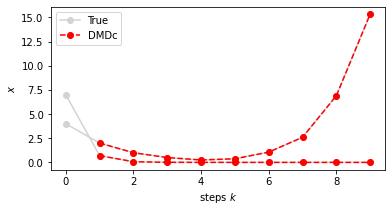

In [54]:
xpred = model.simulate(x[0,:], C, n_steps=n-1)

fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot()
ax.plot(np.linspace(0,n-1,n),x[:,0],'-o', color='lightgrey', label='True')
ax.plot(np.linspace(0,n-1,n),x[:,1],'-o', color='lightgrey')
ax.plot(np.linspace(1,n-1,n-1),xpred[:,0],'--or', label='DMDc')
ax.plot(np.linspace(1,n-1,n-1),xpred[:,1],'--or')
ax.set(
        ylabel=r'$x$',
        xlabel=r'steps $k$')
ax.legend()
